/Users/tomcuel/.venvs/global_env/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loading MNIST dataset...
Preprocessing data...


/Users/tomcuel/.venvs/global_env/lib/python3.13/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(48999, 784) (10500, 784) (10501, 784) float64
(48999,) (10500,) (10501,) int64


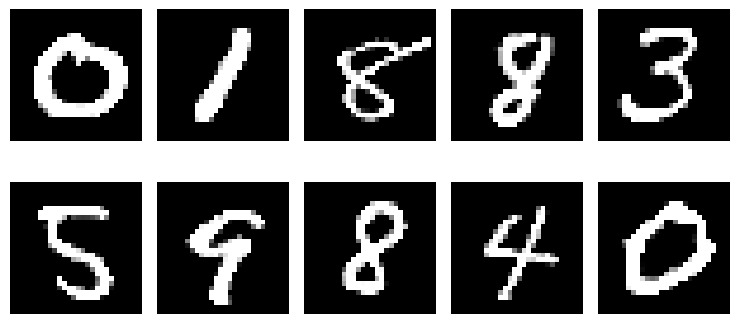

/Users/tomcuel/.venvs/global_env/lib/python3.13/site-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/30
1532/1532 ━━━━━━━━━━━━━━━━━━━━ 1s 600us/step - accuracy: 0.8330 - loss: 0.5685 - val_accuracy: 0.9396 - val_loss: 0.2201
Epoch 2/30
1532/1532 ━━━━━━━━━━━━━━━━━━━━ 1s 552us/step - accuracy: 0.9510 - loss: 0.1706 - val_accuracy: 0.9506 - val_loss: 0.1853
Epoch 3/30
1532/1532 ━━━━━━━━━━━━━━━━━━━━ 1s 547us/step - accuracy: 0.9654 - loss: 0.1203 - val_accuracy: 0.9555 - val_loss: 0.1734
Epoch 4/30
1532/1532 ━━━━━━━━━━━━━━━━━━━━ 1s 530us/step - accuracy: 0.9721 - loss: 0.0944 - val_accuracy: 0.9577 - val_loss: 0.1709
Epoch 5/30
1532/1532 ━━━━━━━━━━━━━━━━━━━━ 1s 552us/step - accuracy: 0.9774 - loss: 0.0777 - val_accuracy: 0.9584 - val_loss: 0.1783
Epoch 6/30
1532/1532 ━━━━━━━━━━━━━━━━━━━━ 1s 530us/step - accuracy: 0.9807 - loss: 0.0658 - val_accuracy: 0.9575 - val_loss: 0.1826
Epoch 7/30
1532/1532 ━━━━━━━━━━━━━━━━━━━━ 1s 564us/step - accuracy: 0.9841 - loss: 0.0574 - val_accuracy: 0.9596 - val_loss: 0.1876
Epoch 8/30
1532/1532 ━━━━━━━━━━━━━━━━━━━━ 1s 533us/step - accuracy: 0.9866 -

In [ ]:
# ===============================
# Deep Neural Network using Tensorflow
# Dataset: MNIST (Handwritten Digit Recognition)
# ===============================

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from typing import List, Optional, Tuple
from functools import partial
import optuna

RNG_SEED = 42
np.random.seed(RNG_SEED)
tf.random.set_seed(RNG_SEED)


# =======================================
# 1. Load and Preprocess Data
# =======================================
def show_images(image, num_row=2, num_col=5):
    # plot images
    image_size = int(np.sqrt(image.shape[-1]))
    image = np.reshape(image, (image.shape[0], image_size, image_size))
    fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
    for i in range(num_row*num_col):
        ax = axes[i//num_col, i%num_col]
        ax.imshow(image[i], cmap='gray', vmin=0, vmax=1)
        ax.axis('off')
    plt.tight_layout()
    plt.show()
    
print("Loading MNIST dataset...")
mnist_data = fetch_openml("mnist_784", version=1, as_frame=False)
X = mnist_data["data"]
y = mnist_data["target"]

# Normalize
print("Preprocessing data...")
scaler = StandardScaler()
X = scaler.fit_transform(X)

# One-hot encode labels
encoder = LabelEncoder()
y = encoder.fit_transform(y.reshape(-1, 1))

def train_val_test_split(X, y, train_size=0.7, val_size=0.15, test_size=0.15, random_state=42):
    assert abs(train_size + val_size + test_size - 1.0) < 1e-6, "Sizes must sum to 1"

    # First split: train vs temp (val+test)
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=(1 - train_size), random_state=random_state, stratify=y)

    # Compute proportion of validation relative to temp
    val_prop = val_size / (val_size + test_size)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=(1 - val_prop), random_state=random_state, stratify=y_temp)

    return X_train, X_val, X_test, y_train, y_val, y_test

# Usage:
X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(X, y)
print(X_train.shape, X_val.shape, X_test.shape,  X_train.dtype)
print(y_train.shape, y_val.shape, y_test.shape,  y_train.dtype)
input_dim = int(X_train.shape[1])
output_dim = int(len(np.unique(y_train)))
show_images(X_train)


# =======================================
# 2. Test Tensorflow  
# =======================================
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(input_dim,)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(output_dim, activation='softmax')
])
# Compile model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
# Train
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=32,
    verbose=1
)
# Evaluate
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc:.4f}")
